In [1]:
import os
from tqdm.notebook import tqdm
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Existing dataset dir
data_dir = './data/'

# Existing plots dir
plots_dir = data_dir+'/plots/'
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


In [3]:
colors = {'red': '#ee443a', 'blue': '#42bbf1', 'dark_blue': '#1a4fec',
          'green': '#50be61', 'grey': '#b7b7b7', 'orange': '#f28222', 'purple': '#6e18ee', 'brown': '#a65628', 'pink': '#ef4793',
          'yellow': '#f8c94c', 'black': '#000000', 'white': '#ffffff', 'light_blue': '#a6cee3', 'light_green': '#b2df8a',
          'light_grey': '#999999', 'light_orange': '#fdbf6f', 'light_purple': '#cab2d6', 'light_brown': '#ffff99', 'light_pink': '#1f78b4',
          'light_yellow': '#fb9a99', 'light_black': '#e31a1c', 'light_white': '#33a02c', 'gold': '#ff7f00', 'silver': '#b2df8a'}


plot_settings = {
    'arbitrum': {'color': colors['blue'],   'label': 'Arbitrum', 'style': 'solid', 'width': 4, 'marker_symbol': 'circle'},
    'base': {'color': colors['red'],        'label': 'Base', 'style': 'dash', 'width': 3.5, 'marker_symbol': 'diamond'},
    'ethereum': {'color': colors['green'],  'label': 'Ethereum', 'style': 'dot', 'width': 3, 'marker_symbol': 'square'},
    'optimism': {'color': colors['grey'],   'label': 'Optimism', 'style': 'dashdot', 'width': 2.5, 'marker_symbol': 'triangle-up'},
    'zksync': {'color': colors['pink'],     'label': 'zkSync', 'style': 'solid', 'width': 2, 'marker_symbol': 'cross'},
    'arbitrum2': {'color': colors['brown'],    'label': 'Fantom', 'style': 'dash', 'width': 1.5, 'marker_symbol': 'star'},
}

file_settings = {
    'ethereum': {  'nr': '1', 'file_name': './data/mav-ethereum-Uniswap-v3-WETH-USDC.paraquet' , 'output_file': './data/mav2-ethereum-Uniswap-v3-WETH-USDC.paraquet' },
    'arbitrum': {  'nr': '2', 'file_name': './data/mav-arbitrum-Uniswap-v3-WETH-USDC.paraquet' , 'output_file': './data/mav2-arbitrum-Uniswap-v3-WETH-USDC.paraquet'},
    'arbitrum2': { 'nr': '3', 'file_name': './data/mav-arbitrum-Uniswap-v3-WETH-USDCe.paraquet', 'output_file': './data/mav2-arbitrum-Uniswap-v3-WETH-USDCe.paraquet'},
    'base': {      'nr': '4', 'file_name': './data/mav-base-Uniswap-v3-WETH-USDC.paraquet'     , 'output_file': './data/mav2-base-Uniswap-v3-WETH-USDC.paraquet'},
    'optimism': {  'nr': '5', 'file_name': './data/mav-optimism-Uniswap-v3-WETH-USDC.paraquet' , 'output_file': './data/mav2-optimism-Uniswap-v3-WETH-USDC.paraquet'},
    'zksync': {    'nr': '6', 'file_name': './data/mav-zksync-Uniswap-v3-WETH-USDC.paraquet'   , 'output_file': './data/mav2-zksync-Uniswap-v3-WETH-USDC.paraquet' } ,
}

columns = ["Binance","Ethereum","Arbitrum","Arbitrum(e)","Base", "Optimism(e)", "zkSync(e)"]
price_diff_matrix = np.zeros((7, 7))
MAV_matrix = np.zeros((7, 7))

In [4]:

def calculateV_MAX2(reserves_y, price_AMM, price_CEX):
    return abs((reserves_y * (price_AMM - price_CEX) / (2 * price_AMM)))

def calculateMAV2(reserves_y, price_AMM, price_CEX, A):
    return (reserves_y * (price_AMM - price_CEX) ** 2 / (4 * price_AMM))

def calculateV_MAX(reserves_y_1, price_AMM_1, reserves_y_2, price_AMM_2):
    return abs(( (price_AMM_1 - price_AMM_2) / (2 * ( price_AMM_1 / reserves_y_1 + price_AMM_2 / reserves_y_2  ))))

def calculateMAV(reserves_y_1, price_AMM_1, price_AMM_2, reserves_y_2):
   return ((price_AMM_1 - price_AMM_2) ** 2 / (4 * ( price_AMM_1 / reserves_y_1 + price_AMM_2 / reserves_y_2 )))

In [5]:
def process_swaps(swaps_df, suffix):


    swaps_df = swaps_df.drop('volume_total_USD', 'balance_total_USD', 'LP_Fee_USD', 'LP_Fee_total_USD', 'LP_fee_p', 'block_slippage_USD', 'MAV_USD_right', 'transaction_hash_right', 'block_timestamp_right',
                             'price_diff', 'r_price_diff', 'MAV_USD', 'V_max_ETH', 'V_max_USD', 'MAV_threshold', 'MAV_cum_sum', 'MAV_groups')

    swaps_df = swaps_df.with_columns(
        price_diff = ((pl.col('spot_price') - pl.col('spot_price'+suffix)).abs()) / pl.col('spot_price'+suffix),
        r_price_diff = ((pl.col('spot_price') - pl.col('spot_price'+suffix)) / pl.col('spot_price'+suffix)),
        #volume_total_USD = pl.col('amount_USD'),
        #balance_total_USD = pl.col('amount_USD'),
        #LP_Fee_USD = pl.col('amount_USD') * fee / 10000,
        #LP_Fee_total_USD = (pl.col('amount_USD') * fee / 10000),
        #LP_fee_p = (fee / 10000)
    )

    #swaps_df = swaps_df.sort(by=['block_number', 'transaction_index'])

    #swaps_df = swaps_df.with_columns(pl.col("balance_total_USD").cum_sum().over("block_number").alias("block_slippage_USD"))
    #swaps_df = swaps_df.with_columns((pl.col("block_slippage_USD") - pl.col("balance_total_USD")).alias("block_slippage_USD"))

    #calulating MAV_0, V_max_0, reserve_total_0, LP_fee_0
    swaps_df = swaps_df.with_columns(
        MAV_USD = calculateMAV(pl.col('reserve_ETH'), pl.col('spot_price'), pl.col('spot_price'+suffix), pl.col('reserve_ETH'+suffix)),
        V_max_ETH = calculateV_MAX(pl.col('reserve_ETH'), pl.col('spot_price'), pl.col('spot_price'+suffix), pl.col('reserve_ETH'+suffix)),
        reserve_total_USD = 2 * pl.col('reserve_ETH')
    )

    swaps_df = swaps_df.with_columns(
        V_max_USD = pl.col('V_max_ETH') * pl.col('spot_price'),
    )


    #calculate threshold for max MAV as  Q3 + 1.5 IQR

    data = swaps_df['price_diff']
    # Calculate Q1 (25th percentile)
    Q1 = np.percentile(data, 25)
    # Calculate Q3 (75th percentile)
    Q3 = np.percentile(data, 75)
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    threshold = Q3 #+ 1.5 * IQR
    print("threshold:", threshold)
    del(data)

    swaps_df = swaps_df.with_columns(
        MAV_threshold = pl.when(pl.col('price_diff') >  threshold).then(0).otherwise(1)
    )
    swaps_df = swaps_df.with_columns(
        MAV_cum_sum = pl.col('MAV_threshold').cum_sum()
    )
    swaps_df = swaps_df.with_columns(
        MAV_groups = pl.when(pl.col('MAV_threshold') >  0).then(0).otherwise(pl.col('MAV_cum_sum'))
    )

    # Perform the aggregation
    max_MAV_df = swaps_df.group_by('MAV_groups').agg(pl.max("MAV_USD").alias("max_MAV_USD"))

    # Join with the original DataFrame to get the corresponding block_timestamp
    max_MAV_df = max_MAV_df.join(
        swaps_df, on="MAV_groups", how="inner"
    ).select([
        "MAV_groups",
        "max_MAV_USD",
        "MAV_USD",
        "transaction_hash",
        "block_timestamp"
    ]).filter(pl.col("MAV_USD") == pl.col("max_MAV_USD")).filter(pl.col("MAV_groups") != 0)

    max_MAV_df = max_MAV_df.group_by('MAV_groups').agg(pl.last("max_MAV_USD"), pl.last("transaction_hash"), pl.last("block_timestamp"))

    swaps_df = swaps_df.join(max_MAV_df, on="MAV_groups", how="left")

    swaps_df = swaps_df.with_columns(
        decay = pl.when(pl.col('block_timestamp') > pl.col('block_timestamp_right'))
                .then(pl.col('block_timestamp') - pl.col('block_timestamp_right'))
                .otherwise(pl.lit(0)),
        max_MAV_USD = pl.when(pl.col('transaction_hash') == pl.col('transaction_hash_right'))
                .then(pl.col('MAV_USD'))
                .otherwise(pl.lit(0))
    )
    return swaps_df


In [6]:

for key0, value0 in file_settings.items():
    file_name0 = value0['file_name']
    nr0 = int(value0['nr'])

    #Binance
    nr1 = 0 
    swaps_df0 = pl.scan_parquet(file_name0).collect(streaming=True)
    price_diff = abs(swaps_df0['r_price_diff']).mean()
    price_diff_matrix[0, nr0] = price_diff
    price_diff_matrix[nr0, 0] = price_diff
    MAV = swaps_df0['max_MAV_USD'].sum()
    MAV_matrix[0, nr0] = MAV
    MAV_matrix[nr0, 0] = MAV
    del swaps_df0

    print("loop: " + value0['nr'])

    #start calculations
    for key1, value1 in file_settings.items():

        suffix = "_" + value1['nr']
        nr1 = int(value1['nr'])

        if (nr0 != nr1) : #& (nr0==6)) :
            swaps_df0 = pl.scan_parquet(file_name0).collect(streaming=True)

            print(suffix)
            file_name1 = value1['file_name']

            swaps_df_full = pl.scan_parquet(file_name1).collect(streaming=True)
            swaps_df_full = swaps_df0.join(swaps_df_full, on='block_timestamp', how="outer", suffix=suffix)
            #del swaps_df1

            swaps_df_full = swaps_df_full.with_columns(
                pl.when(pl.col("block_timestamp").is_not_null())
                .then(pl.col("block_timestamp") )
                .otherwise(pl.col("block_timestamp"+suffix) )
                .alias("block_timestamp_X")
            )
            swaps_df_full = swaps_df_full.sort("block_timestamp_X")

            swaps_df_full = swaps_df_full.with_columns(pl.col("spot_price"+suffix).fill_null(strategy="forward"))
            swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_USD"+suffix).fill_null(strategy="forward"))
            swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_ETH"+suffix).fill_null(strategy="forward"))
            swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_total_USD"+suffix).fill_null(strategy="forward"))

            swaps_df_full = swaps_df_full.select("block_timestamp", "spot_price"+suffix, "reserve_USD"+suffix, "reserve_ETH"+suffix, "reserve_total_USD"+suffix)
            swaps_df0 = swaps_df0.join(swaps_df_full, on = "block_timestamp", how="left")
            del swaps_df_full

            swaps_df0 = swaps_df0.filter(pl.col('spot_price'+suffix).is_not_null())
            swaps_df0 = process_swaps(swaps_df0, suffix)

            #swaps_df0 = swaps_df0.with_columns(
            #    ((pl.col("spot_price"+suffix) - pl.col("spot_price")).abs() / pl.col("spot_price")).alias("r_price_diff" + suffix)
            #)

            price_diff = swaps_df0["price_diff"].mean()
            price_diff_matrix[nr0, nr1] = price_diff
            
            MAV = swaps_df0['max_MAV_USD'].sum()
            MAV_matrix[nr0, nr1] = MAV
            print(MAV)

            del swaps_df0



loop: 1
_2
threshold: 0.0005172973168060698
29078129.182193108
_3
threshold: 0.0005135173720700959
36274501.7480322
_4
threshold: 0.001022002420450998
9278816.68041543
_5
threshold: 0.000540012037869631
6881640.85308573
_6
threshold: 0.0031015155899632605
312415.21687787
loop: 2
_1
threshold: 0.0005459591667063893
18716477.528365128
_3
threshold: 0.00024453953515300866
25514785.336999778
_4
threshold: 0.0006390810366398603
5178739.784265256
_5
threshold: 0.0003922791627547495
1588680.551166657
_6
threshold: 0.0030551192892305313
41710.23610370867
loop: 3
_1
threshold: 0.000850604591926651
27227091.074726246
_2
threshold: 0.0002881651458912227
24338432.642444815
_4
threshold: 0.0013665785479237793
3959531.2927995166
_5
threshold: 0.0006210682381687919
3338519.8190404447
_6
threshold: 0.003915509281703245
231403.83299477046
loop: 4
_1
threshold: 0.0008517116556549173
7628839.914488014
_2
threshold: 0.0005875576740612227
4052617.3485358483
_3
threshold: 0.0008651721609506393
3734287.95625

In [7]:
print(price_diff_matrix)

[[0.         0.00049962 0.00032142 0.00035561 0.00073072 0.00046957
  0.00224491]
 [0.00049962 0.         0.00075826 0.00103097 0.00113841 0.00099021
  0.00256281]
 [0.00032142 0.00048017 0.         0.00019789 0.0007065  0.00033742
  0.0022539 ]
 [0.00035561 0.00073766 0.000234   0.         0.00117757 0.00054419
  0.00287352]
 [0.00073072 0.00076902 0.0006232  0.00078282 0.         0.00071326
  0.00212263]
 [0.00046957 0.00061412 0.00043966 0.00049025 0.00122994 0.
  0.00298179]
 [0.00224491 0.00206772 0.00244529 0.00246939 0.00196945 0.00216052
  0.        ]]


In [8]:
print(MAV_matrix)

[[0.00000000e+00 5.24878305e+07 2.69939460e+06 2.70694782e+06
  1.29429131e+06 6.90855916e+05 2.01103805e+04]
 [5.24878305e+07 0.00000000e+00 2.90781292e+07 3.62745017e+07
  9.27881668e+06 6.88164085e+06 3.12415217e+05]
 [2.69939460e+06 1.87164775e+07 0.00000000e+00 2.55147853e+07
  5.17873978e+06 1.58868055e+06 4.17102361e+04]
 [2.70694782e+06 2.72270911e+07 2.43384326e+07 0.00000000e+00
  3.95953129e+06 3.33851982e+06 2.31403833e+05]
 [1.29429131e+06 7.62883991e+06 4.05261735e+06 3.73428796e+06
  0.00000000e+00 1.05427639e+06 1.16002095e+05]
 [6.90855916e+05 4.82837423e+06 1.44277822e+06 2.69999634e+06
  8.90709993e+05 0.00000000e+00 1.03856065e+05]
 [2.01103805e+04 1.76988662e+04 5.77703772e+03 4.28111927e+04
  7.73267371e+03 2.15628720e+04 0.00000000e+00]]


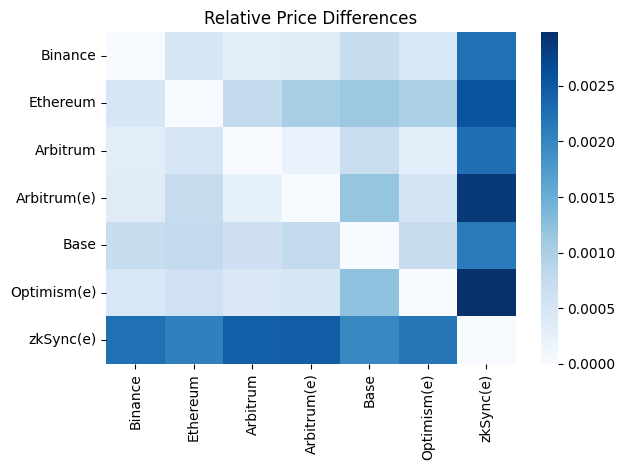

In [9]:

# Default heatmap
p1 = sns.heatmap(price_diff_matrix, cmap="Blues")
p1.set_xticklabels(columns, rotation=90)
p1.set_yticklabels(columns, rotation=0)

p1.set_title("Relative Price Differences")

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig("heatmap_price.pdf", format="pdf")

# Show the plot (optional, can be omitted if not needed)
plt.show()

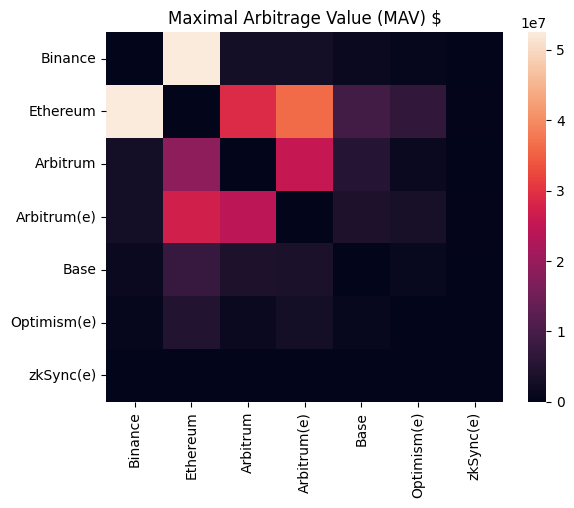

In [10]:


# Default heatmap
p1 = sns.heatmap(MAV_matrix)
p1.set_xticklabels(columns, rotation=90)
p1.set_yticklabels(columns, rotation=0)

p1.set_title("Maximal Arbitrage Value (MAV) $")

# Save the plot as a PDF file
plt.savefig("heatmap_MAV.pdf", format="pdf")

# Show the plot (optional, can be omitted if not needed)
plt.show()

/var/folders/y_/27jchs_x56gfpv07wkchjxj40000gn/T/ipykernel_7324/4280741519.py:8: RuntimeWarning: divide by zero encountered in log10
  log_MAV_matrix = np.log10(MAV_matrix)


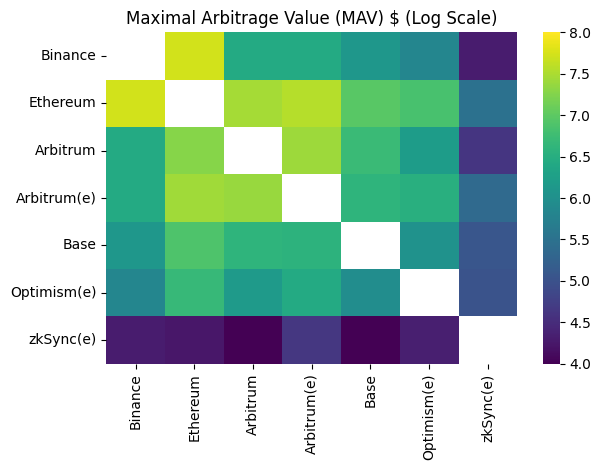

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume MAV_matrix and columns are already defined

# Apply logarithmic transformation
log_MAV_matrix = np.log10(MAV_matrix)

# Create the heatmap with log-transformed data
p1 = sns.heatmap(log_MAV_matrix, cmap='viridis', vmin=4, vmax=8)
p1.set_xticklabels(columns, rotation=90)
p1.set_yticklabels(columns, rotation=0)

p1.set_title("Maximal Arbitrage Value (MAV) $ (Log Scale)")

plt.tight_layout()
# Save the plot as a PDF file
plt.savefig("heatmap_MAV_log.pdf", format="pdf")

# Show the plot (optional, can be omitted if not needed)
plt.show()

In [12]:
log_MAV_matrix

array([[      -inf, 7.72005862, 6.43126638, 6.43247988, 6.11203204,
        5.83938748, 4.30342029],
       [7.72005862,       -inf, 7.46356646, 7.55960146, 6.96749259,
        6.837692  , 5.49473218],
       [6.43126638, 7.27222412,       -inf, 7.40679192, 6.71422409,
        6.20103658, 4.62024265],
       [6.43247988, 7.43500124, 7.38629261,       -inf, 6.59764378,
        6.52355396, 5.36437055],
       [6.11203204, 6.8824585 , 6.6077356 , 6.5722078 ,       -inf,
        6.02295448, 5.06446583],
       [5.83938748, 6.68380092, 6.15919958, 6.43136318, 5.94973632,
              -inf, 5.01643186],
       [4.30342029, 4.24794545, 3.7617052 , 4.63155733, 3.88832969,
        4.3337066 ,       -inf]])

In [13]:
print(MAV_matrix)

[[0.00000000e+00 5.24878305e+07 2.69939460e+06 2.70694782e+06
  1.29429131e+06 6.90855916e+05 2.01103805e+04]
 [5.24878305e+07 0.00000000e+00 2.90781292e+07 3.62745017e+07
  9.27881668e+06 6.88164085e+06 3.12415217e+05]
 [2.69939460e+06 1.87164775e+07 0.00000000e+00 2.55147853e+07
  5.17873978e+06 1.58868055e+06 4.17102361e+04]
 [2.70694782e+06 2.72270911e+07 2.43384326e+07 0.00000000e+00
  3.95953129e+06 3.33851982e+06 2.31403833e+05]
 [1.29429131e+06 7.62883991e+06 4.05261735e+06 3.73428796e+06
  0.00000000e+00 1.05427639e+06 1.16002095e+05]
 [6.90855916e+05 4.82837423e+06 1.44277822e+06 2.69999634e+06
  8.90709993e+05 0.00000000e+00 1.03856065e+05]
 [2.01103805e+04 1.76988662e+04 5.77703772e+03 4.28111927e+04
  7.73267371e+03 2.15628720e+04 0.00000000e+00]]


In [14]:
chain0 = 'zksync'
chain1 = 'arbitrum'

file_name0 = file_settings[chain0]['file_name']
file_name1 = file_settings[chain1]['file_name']

nr0 = int(file_settings[chain0]['nr'])
nr1 = int(file_settings[chain1]['nr'])
suffix = "_" + file_settings[chain1]['nr']

wfwe fwewefw

SyntaxError: invalid syntax (1446708941.py, line 11)

In [ ]:
price_diff_matrix = np.zeros((7, 7))
MAV_matrix = np.zeros((7, 7))


swaps_df0 = pl.scan_parquet(file_name0).collect(streaming=True)

price_diff = abs(swaps_df0['r_price_diff']).mean()
price_diff_matrix[0, nr0] = price_diff
price_diff_matrix[nr0, 0] = price_diff
MAV = swaps_df0['max_MAV_USD'].sum()
MAV_matrix[0, nr0] = MAV
MAV_matrix[nr0, 0] = MAV
print("loop: " + value0['nr'])


swaps_df_full = pl.scan_parquet(file_name1).collect(streaming=True)

swaps_df_full = swaps_df0.join(swaps_df_full, on='block_timestamp', how="outer", suffix=suffix)


swaps_df_full = swaps_df_full.with_columns(
    pl.when(pl.col("block_timestamp").is_not_null())
    .then(pl.col("block_timestamp") )
    .otherwise(pl.col("block_timestamp"+suffix) )
    .alias("block_timestamp_X")
)
swaps_df_full = swaps_df_full.sort("block_timestamp_X")

swaps_df_full = swaps_df_full.with_columns(pl.col("spot_price"+suffix).fill_null(strategy="forward"))
swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_USD"+suffix).fill_null(strategy="forward"))
swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_ETH"+suffix).fill_null(strategy="forward"))
swaps_df_full = swaps_df_full.with_columns(pl.col("reserve_total_USD"+suffix).fill_null(strategy="forward"))

swaps_df_full = swaps_df_full.select("block_timestamp", "spot_price"+suffix, "reserve_USD"+suffix, "reserve_ETH"+suffix, "reserve_total_USD"+suffix)
swaps_df0 = swaps_df0.join(swaps_df_full, on = "block_timestamp", how="left")
del swaps_df_full

print(swaps_df0.shape[0])
swaps_df0 = swaps_df0.filter(pl.col('spot_price'+suffix).is_not_null())
print(swaps_df0.shape[0])
swaps_df0 = process_swaps(swaps_df0, suffix)
print(swaps_df0.shape[0])
#swaps_df0 = swaps_df0.with_columns(
#    ((pl.col("spot_price"+suffix) - pl.col("spot_price")).abs() / pl.col("spot_price")).alias("r_price_diff" + suffix)
#)

#price_diff = swaps_df0["r_price_diff" + suffix].mean()
#price_diff_matrix[nr1, nr0] = price_diff

swaps_df0 = swaps_df0.with_columns(
    ((pl.col("spot_price") - pl.col("spot_price"+suffix)).abs() / pl.col("spot_price"+suffix)).alias("price_diff")
)

price_diff = swaps_df0["price_diff"].mean()

price_diff_matrix[nr0, nr1] = price_diff

MAV = swaps_df0['max_MAV_USD'].sum()
MAV_matrix[nr0, nr1] = MAV
print(MAV)

#del swaps_df0


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume MAV_matrix and columns are already defined

# Apply logarithmic transformation
log_MAV_matrix = np.log10(MAV_matrix)

# Create the heatmap with log-transformed data
p1 = sns.heatmap(log_MAV_matrix, cmap='viridis')
p1.set_xticklabels(columns, rotation=90)
p1.set_yticklabels(columns, rotation=0)

p1.set_title("Maximal Arbitrage Value (MAV) $ (Log Scale)")

# Save the plot as a PDF file
plt.savefig("heatmap_MAV_log.pdf", format="pdf")

# Show the plot (optional, can be omitted if not needed)
plt.show()

In [ ]:
print(MAV_matrix)

In [ ]:
swaps_df0

In [ ]:

swaps_df00 = pl.scan_parquet(file_name0).collect(streaming=True)


In [ ]:
swaps_df1 = pl.scan_parquet(file_name1).collect(streaming=True)
min = swaps_df1['block_timestamp'].min()
max = swaps_df1['block_timestamp'].max()

In [ ]:
print(min)
print(max)